# Simulation, WP matrix

in this notebook I compare the simulated waveform simply using the WP from COMSOL with alpha events

In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

In [2]:
path_to_reduced = '/p/lustre1/jacopod/30th/'
!ls $path_to_reduced

20200911_OvernightBi207_AfterFilling
20200912_MorningNoise_PreRecirculation
20200915_Night_AfterFirstRnInjection
20200915_Night_Noise
20200916_Morning_Noise
20200916_Night_AfterSecondRnInjection
20200916_RnPoAlphaEffTest
20200917_Night_AfterThirdRnInjection
20200920_Rn220InParallel_RnPoTest
20200921_Afternoon_AfterFourthInjection
20200922_Afternoon_AfterFifthInjection
20200923_Afternoon_AfterSixthInjection
20200924_Afternoon_AfterSeventhInjection
20201207_alpha_sim
20210502_bipo_sim
20210512_207Bi_sim
config
selected_dataset


In [3]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run30.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx'
sample_window = 1000
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile( run_parameters_file, '20200916_RnPoAlphaEffTest' )
analysis_config.GetCalibrationConstantsFromFile( calibrations_file)
analysis_config.GetChannelMapFromFile( channel_map_file, '20200916_RnPoAlphaEffTest' )
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
simulated_sampling_rate = analysis_config.run_parameters['Simulation Sampling Rate [MHz]']
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Fully simulated waveform - Alpha comparison

In [4]:
def fit_test_mod(wfm,test,freq):
    numerator = np.square((wfm-test)/freq)
    mod_chi2 = sum(numerator)
    return mod_chi2/(len(wfm)-1)

The way I removed the wrongly aligned waveforms is to calculate the differential waveform (current), the maximum in the current is the inflection point of the waveform risetime. If the inflection point is distant to the recorded T90 more than wait_time_us=1.2us the event is discarded

In [5]:
path_to_data = '../data'
!ls $path_to_data

double_strip_data_30th_alpha_improved_reject
double_strip_data_30th_alpha_reject
double_strip_data_30th_bipo_improved_reject
double_strip_data_30th_bipo_reject
double_strip_sim_30th_alpha_noise
double_strip_sim_30th_alpha_noise_uncalibrated
double_strip_sim_30th_alpha_no_noise
double_strip_sim_30th_bipo_noise
double_strip_sim_30th_bipo_no_noise
legacy
strip_data_30th_alpha_improved_reject
strip_data_30th_alpha_reject
strip_data_30th_bipo_improved_reject
strip_data_30th_bipo_reject
strip_sim_30th_alpha_noise
strip_sim_30th_alpha_noise_uncalibrated
strip_sim_30th_alpha_no_noise
strip_sim_30th_bipo_noise
strip_sim_30th_bipo_no_noise


In [6]:
drift_velocity = analysis_config.run_parameters['Drift Velocity [mm/us]']
z_slice = np.linspace(10,70,5)*drift_velocity

In [7]:
data_strip_input = pd.read_hdf('../data/strip_data_30th_bipo_improved_reject')
sim_strip_input = pd.read_hdf('../data/strip_sim_30th_bipo_no_noise')

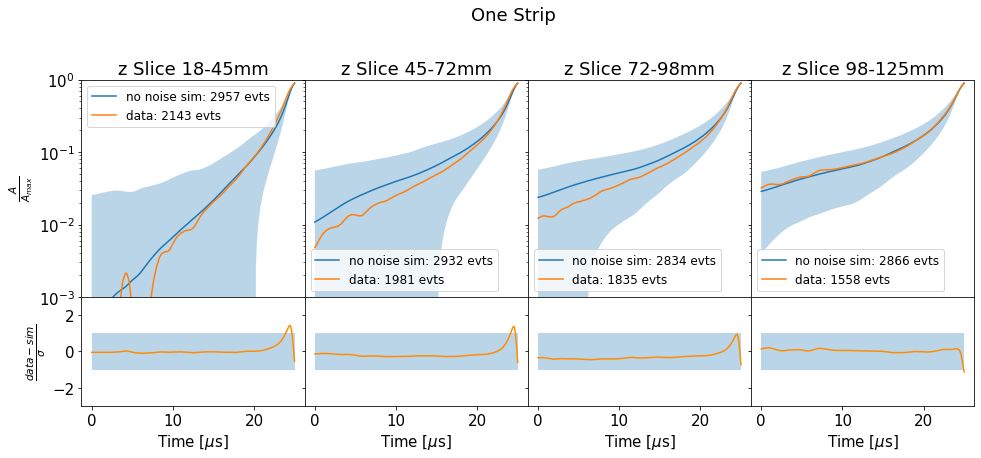

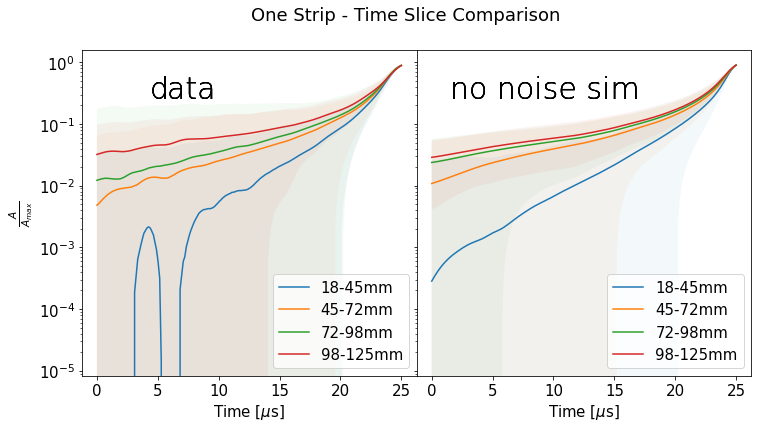

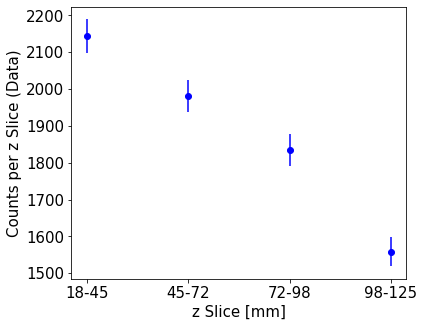

In [8]:
comparison_window_us = 25.0
data_keys = data_strip_input.keys()
sim_keys = sim_strip_input.keys()
sim_sample = len(sim_strip_input[sim_keys[0]][1])
data_sample = len(data_strip_input[data_keys[0]][1])
fig,ax = plt.subplots(2,len(data_keys),sharex=True,sharey='row',\
                      gridspec_kw={'wspace': 0,'hspace': 0,'height_ratios': [2, 1]})

fig.set_size_inches(16,6)
plt.suptitle('One Strip',y=1.05)
ax[0,0].set_ylabel(r'$\frac{A}{A_{max}}$')
ax[1,0].set_ylabel(r'$\frac{data-sim}{\sigma}$')
#fig1 = plt.figure(2)
fig1,ax1 = plt.subplots(1,2,sharey=True,gridspec_kw={'wspace': 0,'hspace': 0})
fig1.set_size_inches(12,6)
plt.suptitle('One Strip - Time Slice Comparison')
for a in ax1:
    a.set_xlabel('Time [$\mu$s]')
ax1[0].set_ylabel(r'$\frac{A}{A_{max}}$')
fig2 = plt.figure(3)
fig2.set_size_inches(6,5)
ax2 = plt.subplot()
ax2.set_xticks(range(len(data_keys)+1))
ax2.set_xticklabels(['{:.0f}-{:.0f}'.format(z_slice[j],z_slice[j+1]) for j in range(len(data_keys))])
ax2.set_xlabel('z Slice [mm]')
ax2.set_ylabel('Counts per z Slice (Data)')
for i,k in enumerate(data_keys):
    try:
        plt.figure(fig.number)
        downsampled_data = data_strip_input[k][1][::int(data_sample/sim_sample)][1:sim_sample+1]
        downsampled_sigma = data_strip_input[k][2][::int(data_sample/sim_sample)][1:sim_sample+1]
        sim_label = 'no noise sim: %i evts'%sim_strip_input[sim_keys[i]][0]
        data_label = 'data: %i evts'%data_strip_input[k][0]
        sim_mean = sim_strip_input[sim_keys[i]][1]
        sim_delta = sim_strip_input[sim_keys[i]][2]
        #plt.figure(fig1.number)
        ax[0,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                           alpha=0.3)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label=sim_label)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label=data_label)
        ax[0,i].set_yscale('log')
        ax[0,i].set_title('z Slice {:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax[0,i].legend(prop={'size': 12})
        #ax[0,i].set_xlim(0.0,12.5)
        ax[0,i].set_ylim(0.001,1.0)
        chi2 = fit_test_mod(downsampled_data,sim_mean,sim_delta)
        #ax[1,i].text(0.4, 0.1, r'$\tilde{\chi}^2$:'+' {:.2f}'.format(chi2), transform=ax[1,i].transAxes,size=20,fontweight='light')
        ax[1,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),-1,1,alpha=0.3,label='1-$\sigma$ band')
        ax[1,i].plot(np.linspace(0,comparison_window_us,sim_sample),(downsampled_data-sim_mean)/sim_delta,\
                     color='darkorange')
        ax[1,i].set_ylim(-3,3)
        ax[1,i].set_xlabel('Time [$\mu$s]')
        #plt.figure(fig1.number)
        ax1[0].fill_between(np.linspace(0,comparison_window_us,sim_sample),downsampled_data-downsampled_sigma,\
                             downsampled_data+downsampled_sigma,alpha=0.05)
        ax1[0].set_yscale('log')
        ax1[0].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[0].text(0.2, 0.85, 'data', transform=ax1[0].transAxes,size=30,fontweight='light')
        ax1[0].legend()
        ax1[1].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                            alpha=0.05)
        ax1[1].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[1].text(0.1, 0.85, 'no noise sim', transform=ax1[1].transAxes,size=30,fontweight='light')
        ax1[1].legend()
        #plt.figure(fig2.number)
        if i == 0:
            ax2.scatter(i,data_strip_input[k][0],c='blue',label='data')
            #ax2.scatter(i,sim_strip_input[sim_keys[i]][0],c='red',label='sim')
        else:
            ax2.scatter(i,data_strip_input[k][0],c='blue')
            #ax2.scatter(i,sim_strip_input[sim_keys[i]][0],c='red')
        ax2.errorbar(i,data_strip_input[k][0],np.sqrt(data_strip_input[k][0]),ecolor='blue')
        #ax2.errorbar(i,sim_strip_input[sim_keys[i]][0],np.sqrt(sim_strip_input[sim_keys[i]][0]),ecolor='red')
        #ax2.legend()
    except TypeError:
        continue
plt.show()

In [9]:
data_strip_input = pd.read_hdf('../data/strip_sim_30th_bipo_noise')

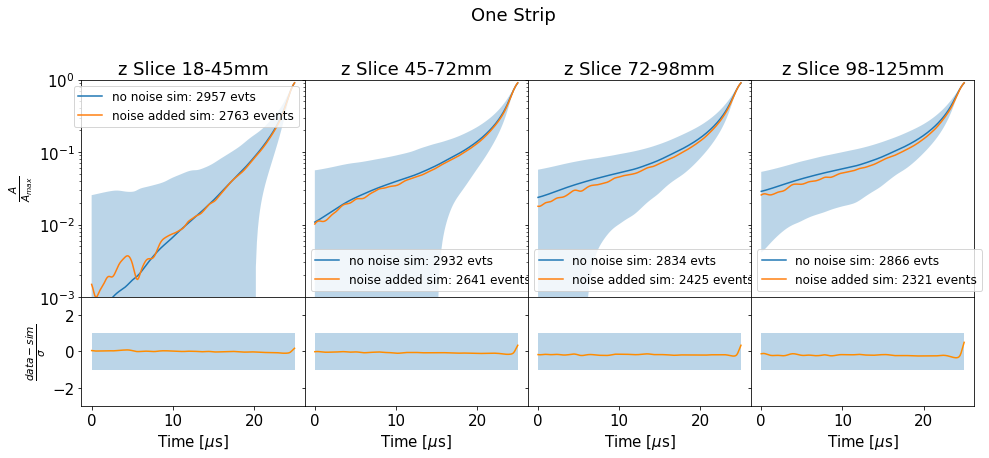

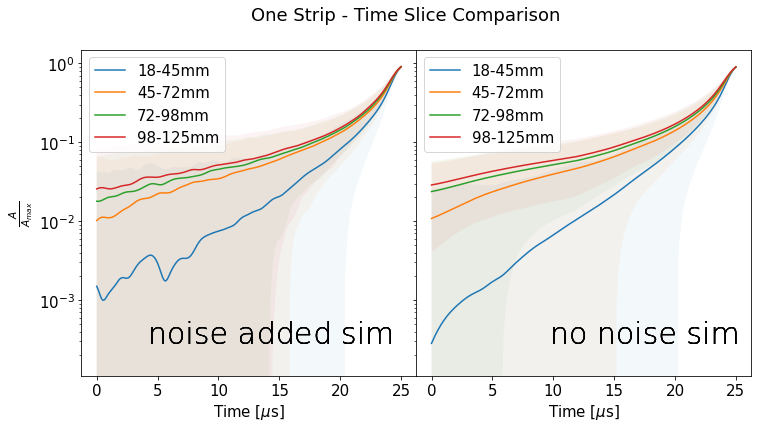

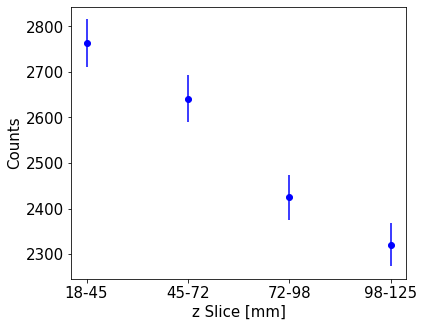

In [10]:
skeys = data_strip_input.keys()
fig,ax = plt.subplots(2,len(skeys),sharex=True,sharey='row',\
                      gridspec_kw={'wspace': 0,'hspace': 0,'height_ratios': [2, 1]})

fig.set_size_inches(16,6)
plt.suptitle('One Strip',y=1.05)
ax[0,0].set_ylabel(r'$\frac{A}{A_{max}}$')
ax[1,0].set_ylabel(r'$\frac{data-sim}{\sigma}$')
#fig1 = plt.figure(2)
fig1,ax1 = plt.subplots(1,2,sharey=True,gridspec_kw={'wspace': 0,'hspace': 0})
fig1.set_size_inches(12,6)
plt.suptitle('One Strip - Time Slice Comparison')
for a in ax1:
    a.set_xlabel('Time [$\mu$s]')
ax1[0].set_ylabel(r'$\frac{A}{A_{max}}$')
fig2 = plt.figure(3)
fig2.set_size_inches(6,5)
ax2 = plt.subplot()
ax2.set_xticks(range(len(skeys)+1))
ax2.set_xticklabels(['{:.0f}-{:.0f}'.format(z_slice[j],z_slice[j+1]) for j in range(len(skeys))])
ax2.set_xlabel('z Slice [mm]')
ax2.set_ylabel('Counts')
for i,k in enumerate(skeys):
    try:
        plt.figure(fig.number)
        downsampled_data = data_strip_input[k][1]
        downsampled_sigma = data_strip_input[k][2]
        sim_label = 'no noise sim: %i evts'%sim_strip_input[k][0]
        data_label = 'noise added sim: %i events'%data_strip_input[k][0]
        sim_mean = sim_strip_input[k][1]
        sim_delta = sim_strip_input[k][2]
        #plt.figure(fig1.number)
        ax[0,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                           alpha=0.3)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label=sim_label)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label=data_label)
        ax[0,i].set_yscale('log')
        ax[0,i].set_title('z Slice {:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax[0,i].legend(prop={'size': 12})
        #ax[0,i].set_xlim(0.0,12.5)
        ax[0,i].set_ylim(0.001,1.0)
        chi2 = fit_test_mod(downsampled_data,sim_mean,sim_delta)
        #ax[1,i].text(0.4, 0.1, r'$\tilde{\chi}^2$:'+' {:.2f}'.format(chi2), transform=ax[1,i].transAxes,size=20,fontweight='light')
        ax[1,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),-1,1,alpha=0.3,label='1-$\sigma$ band')
        ax[1,i].plot(np.linspace(0,comparison_window_us,sim_sample),(downsampled_data-sim_mean)/sim_delta,\
                     color='darkorange')
        ax[1,i].set_ylim(-3,3)
        ax[1,i].set_xlabel('Time [$\mu$s]')
        #plt.figure(fig1.number)
        ax1[0].fill_between(np.linspace(0,comparison_window_us,sim_sample),downsampled_data-downsampled_sigma,\
                             downsampled_data+downsampled_sigma,alpha=0.05)
        ax1[0].set_yscale('log')
        ax1[0].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[0].text(0.2, 0.1, 'noise added sim', transform=ax1[0].transAxes,size=30,fontweight='light')
        ax1[0].legend()
        ax1[1].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                            alpha=0.05)
        ax1[1].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[1].text(0.4, 0.1, 'no noise sim', transform=ax1[1].transAxes,size=30,fontweight='light')
        ax1[1].legend()
        #plt.figure(fig2.number)
        if i == 0:
            ax2.scatter(i,data_strip_input[k][0],c='blue',label='data')
            #ax2.scatter(i,sim_strip_input[k][0],c='red',label='sim')
        else:
            ax2.scatter(i,data_strip_input[k][0],c='blue')
            #ax2.scatter(i,sim_strip_input[k][0],c='red')
        ax2.errorbar(i,data_strip_input[k][0],np.sqrt(data_strip_input[k][0]),ecolor='blue')
       # ax2.errorbar(i,sim_strip_input[k][0],np.sqrt(sim_strip_input[k][0]),ecolor='red')
        #ax2.legend()
    except TypeError:
        continue
plt.show()

In [27]:
double_data_strip_input = pd.read_hdf('../data/double_strip_data_30th_bipo_improved_reject')
double_sim_strip_input = pd.read_hdf('../data/double_strip_sim_30th_bipo_no_noise')

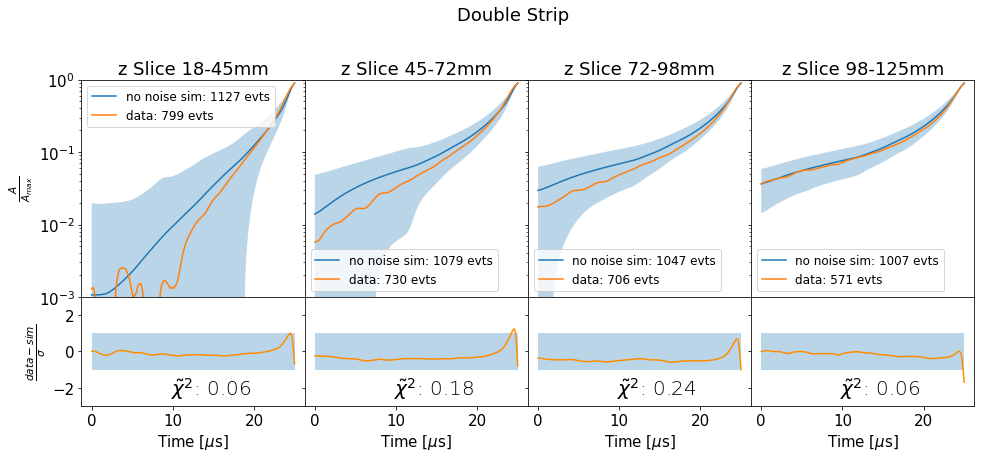

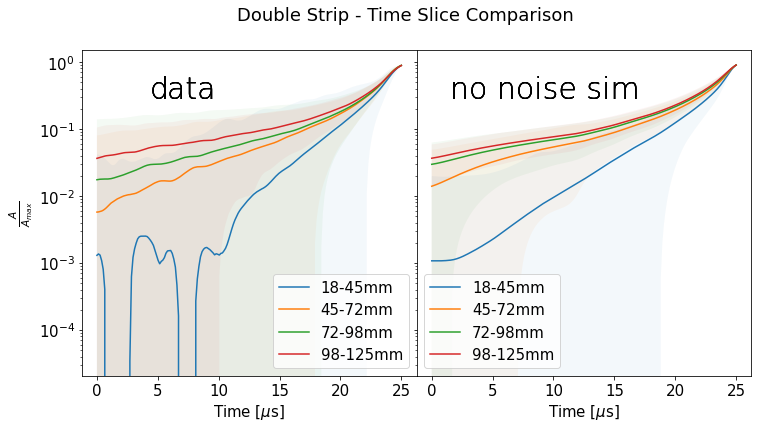

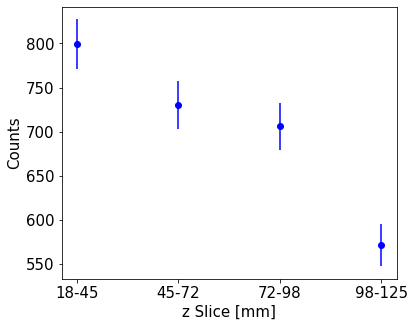

In [28]:
skeys = double_data_strip_input.keys()
fig,ax = plt.subplots(2,len(skeys),sharex=True,sharey='row',\
                      gridspec_kw={'wspace': 0,'hspace': 0,'height_ratios': [2, 1]})

fig.set_size_inches(16,6)
plt.suptitle('Double Strip',y=1.05)
ax[0,0].set_ylabel(r'$\frac{A}{A_{max}}$')
ax[1,0].set_ylabel(r'$\frac{data-sim}{\sigma}$')
#fig1 = plt.figure(2)
fig1,ax1 = plt.subplots(1,2,sharey=True,gridspec_kw={'wspace': 0,'hspace': 0})
fig1.set_size_inches(12,6)
plt.suptitle('Double Strip - Time Slice Comparison')
for a in ax1:
    a.set_xlabel('Time [$\mu$s]')
ax1[0].set_ylabel(r'$\frac{A}{A_{max}}$')
fig2 = plt.figure(3)
fig2.set_size_inches(6,5)
ax2 = plt.subplot()
ax2.set_xticks(range(len(skeys)+1))
ax2.set_xticklabels(['{:.0f}-{:.0f}'.format(z_slice[j],z_slice[j+1]) for j in range(len(skeys))])
ax2.set_xlabel('z Slice [mm]')
ax2.set_ylabel('Counts')
for i,k in enumerate(skeys):
    try:
        plt.figure(fig.number)
        downsampled_data = double_data_strip_input[k][1][::int(data_sample/sim_sample)][1:sim_sample+1]
        downsampled_sigma = double_data_strip_input[k][2][::int(data_sample/sim_sample)][1:sim_sample+1]
        sim_label = 'no noise sim: %i evts'%double_sim_strip_input[sim_keys[i]][0]
        data_label = 'data: %i evts'%double_data_strip_input[k][0]
        sim_mean = double_sim_strip_input[sim_keys[i]][1]
        sim_delta = double_sim_strip_input[sim_keys[i]][2]
        #plt.figure(fig1.number)
        ax[0,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                           alpha=0.3)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label=sim_label)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label=data_label)
        ax[0,i].set_yscale('log')
        ax[0,i].set_title('z Slice {:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax[0,i].legend(prop={'size': 12})
        #ax[0,i].set_xlim(0.0,12.5)
        ax[0,i].set_ylim(0.001,1.0)
        chi2 = fit_test_mod(downsampled_data,sim_mean,sim_delta)
        ax[1,i].text(0.4, 0.1, r'$\tilde{\chi}^2$:'+' {:.2f}'.format(chi2), transform=ax[1,i].transAxes,size=20,fontweight='light')
        ax[1,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),-1,1,alpha=0.3,label='1-$\sigma$ band')
        ax[1,i].plot(np.linspace(0,comparison_window_us,sim_sample),(downsampled_data-sim_mean)/sim_delta,\
                     color='darkorange')
        ax[1,i].set_ylim(-3,3)
        ax[1,i].set_xlabel('Time [$\mu$s]')
        #plt.figure(fig1.number)
        ax1[0].fill_between(np.linspace(0,comparison_window_us,sim_sample),downsampled_data-downsampled_sigma,\
                             downsampled_data+downsampled_sigma,alpha=0.05)
        ax1[0].set_yscale('log')
        ax1[0].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[0].text(0.2, 0.85, 'data', transform=ax1[0].transAxes,size=30,fontweight='light')
        ax1[0].legend()
        ax1[1].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                            alpha=0.05)
        ax1[1].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[1].text(0.1, 0.85, 'no noise sim', transform=ax1[1].transAxes,size=30,fontweight='light')
        ax1[1].legend()
        #plt.figure(fig2.number)
        if i == 0:
            ax2.scatter(i,double_data_strip_input[k][0],c='blue',label='data')
            #ax2.scatter(i,double_sim_strip_input[sim_keys[i]][0],c='red',label='sim')
        else:
            ax2.scatter(i,double_data_strip_input[k][0],c='blue')
            #ax2.scatter(i,double_sim_strip_input[sim_keys[i]][0],c='red')
        ax2.errorbar(i,double_data_strip_input[k][0],np.sqrt(double_data_strip_input[k][0]),ecolor='blue')
        #ax2.errorbar(i,double_sim_strip_input[sim_keys[i]][0],np.sqrt(double_sim_strip_input[sim_keys[i]][0]),ecolor='red')
        #ax2.legend()
    except TypeError:
        continue
plt.show()

In [29]:
double_data_strip_input = pd.read_hdf('../data/double_strip_sim_30th_bipo_noise')

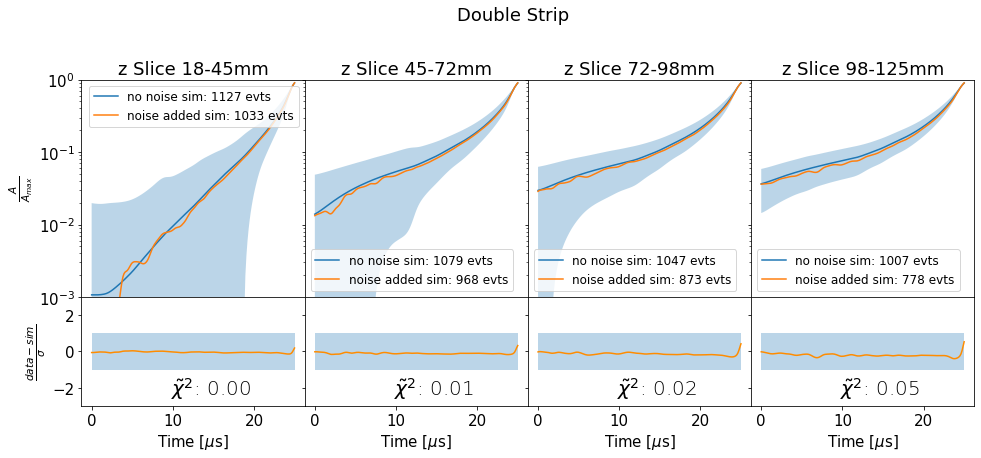

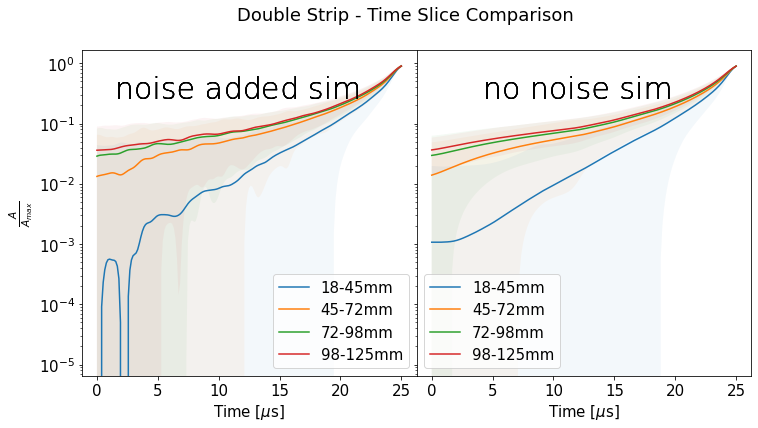

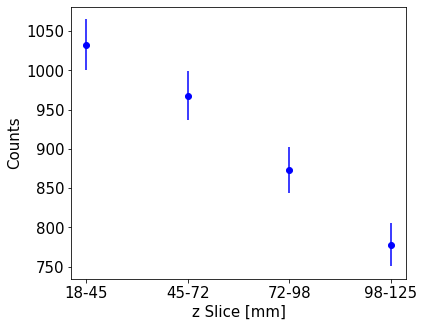

In [31]:
skeys = double_data_strip_input.keys()
fig,ax = plt.subplots(2,len(skeys),sharex=True,sharey='row',\
                      gridspec_kw={'wspace': 0,'hspace': 0,'height_ratios': [2, 1]})

fig.set_size_inches(16,6)
plt.suptitle('Double Strip',y=1.05)
ax[0,0].set_ylabel(r'$\frac{A}{A_{max}}$')
ax[1,0].set_ylabel(r'$\frac{data-sim}{\sigma}$')
#fig1 = plt.figure(2)
fig1,ax1 = plt.subplots(1,2,sharey=True,gridspec_kw={'wspace': 0,'hspace': 0})
fig1.set_size_inches(12,6)
plt.suptitle('Double Strip - Time Slice Comparison')
for a in ax1:
    a.set_xlabel('Time [$\mu$s]')
ax1[0].set_ylabel(r'$\frac{A}{A_{max}}$')
fig2 = plt.figure(3)
fig2.set_size_inches(6,5)
ax2 = plt.subplot()
ax2.set_xticks(range(len(skeys)+1))
ax2.set_xticklabels(['{:.0f}-{:.0f}'.format(z_slice[j],z_slice[j+1]) for j in range(len(skeys))])
ax2.set_xlabel('z Slice [mm]')
ax2.set_ylabel('Counts')
for i,k in enumerate(skeys):
    try:
        plt.figure(fig.number)
        downsampled_data = double_data_strip_input[k][1]
        downsampled_sigma = double_data_strip_input[k][2]
        sim_label = 'no noise sim: %i evts'%double_sim_strip_input[k][0]
        data_label = 'noise added sim: %i evts'%double_data_strip_input[k][0]
        sim_mean = double_sim_strip_input[k][1]
        sim_delta = double_sim_strip_input[k][2]
        #plt.figure(fig1.number)
        ax[0,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                           alpha=0.3)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label=sim_label)
        ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label=data_label)
        ax[0,i].set_yscale('log')
        ax[0,i].set_title('z Slice {:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax[0,i].legend(prop={'size': 12})
        #ax[0,i].set_xlim(0.0,12.5)
        ax[0,i].set_ylim(0.001,1.0)
        chi2 = fit_test_mod(downsampled_data,sim_mean,sim_delta)
        ax[1,i].text(0.4, 0.1, r'$\tilde{\chi}^2$:'+' {:.2f}'.format(chi2), transform=ax[1,i].transAxes,size=20,fontweight='light')
        ax[1,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),-1,1,alpha=0.3,label='1-$\sigma$ band')
        ax[1,i].plot(np.linspace(0,comparison_window_us,sim_sample),(downsampled_data-sim_mean)/sim_delta,\
                     color='darkorange')
        ax[1,i].set_ylim(-3,3)
        ax[1,i].set_xlabel('Time [$\mu$s]')
        #plt.figure(fig1.number)
        ax1[0].fill_between(np.linspace(0,comparison_window_us,sim_sample),downsampled_data-downsampled_sigma,\
                             downsampled_data+downsampled_sigma,alpha=0.05)
        ax1[0].set_yscale('log')
        ax1[0].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[0].text(0.1, 0.85, 'noise added sim', transform=ax1[0].transAxes,size=30,fontweight='light')
        ax1[0].legend()
        ax1[1].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                            alpha=0.05)
        ax1[1].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label='{:.0f}-{:.0f}mm'.format(z_slice[i],z_slice[i+1]))
        ax1[1].text(0.2, 0.85, 'no noise sim', transform=ax1[1].transAxes,size=30,fontweight='light')
        ax1[1].legend()
        #plt.figure(fig2.number)
        if i == 0:
            ax2.scatter(i,double_data_strip_input[k][0],c='blue',label='data')
            #ax2.scatter(i,double_sim_strip_input[k][0],c='red',label='sim')
        else:
            ax2.scatter(i,double_data_strip_input[k][0],c='blue')
            #ax2.scatter(i,double_sim_strip_input[k][0],c='red')
        ax2.errorbar(i,double_data_strip_input[k][0],np.sqrt(double_data_strip_input[k][0]),ecolor='blue')
        #ax2.errorbar(i,double_sim_strip_input[k][0],np.sqrt(double_sim_strip_input[k][0]),ecolor='red')
        #ax2.legend()
    except TypeError:
        continue
plt.show()

In [12]:
data_strip_input = pd.read_hdf('../data/strip_data_30th_bipo_improved_reject')
sim_strip_input = pd.read_hdf('../data/strip_sim_30th_bipo_no_noise')
noise_strip_input = pd.read_hdf('../data/strip_sim_30th_bipo_noise')
double_data_strip_input = pd.read_hdf('../data/double_strip_data_30th_bipo_improved_reject')
double_sim_strip_input = pd.read_hdf('../data/double_strip_sim_30th_bipo_no_noise')
double_noise_strip_input = pd.read_hdf('../data/double_strip_sim_30th_bipo_noise')

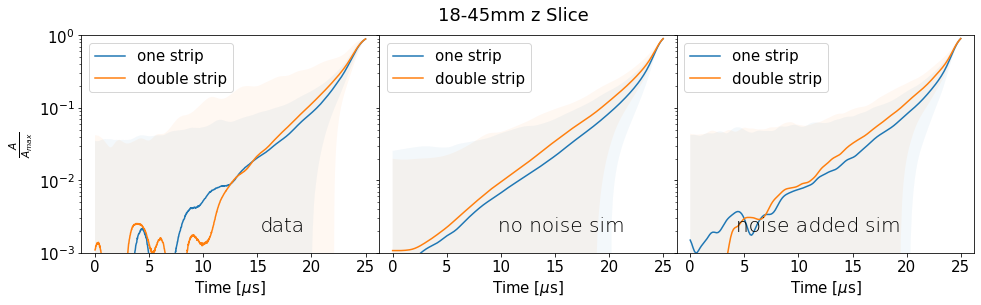

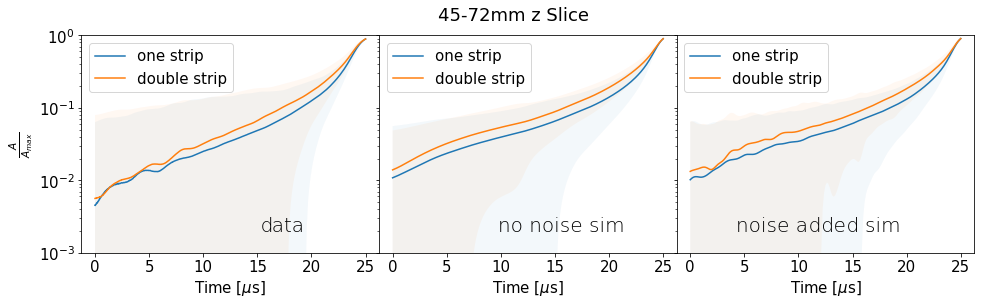

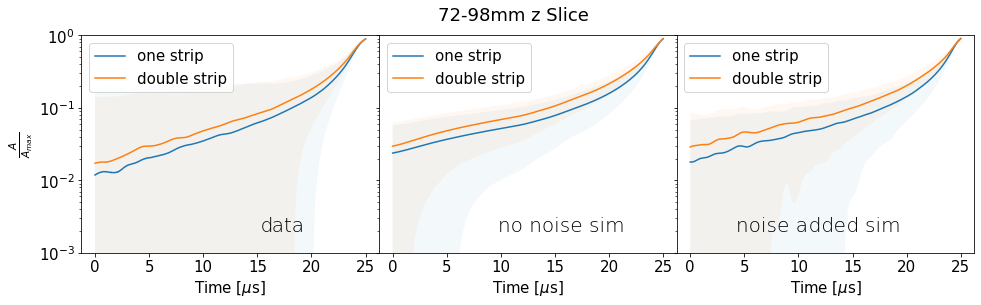

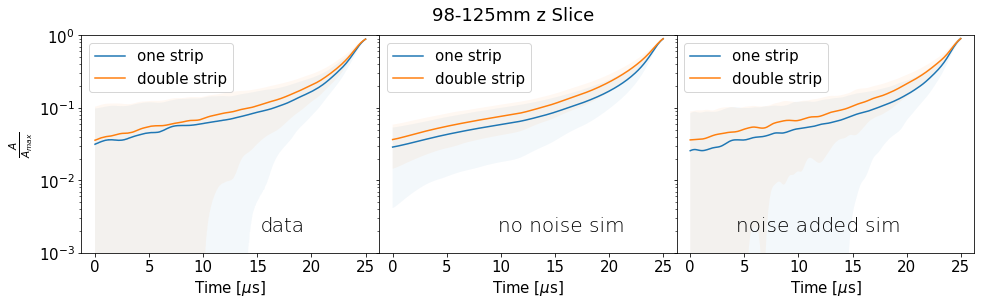

In [14]:
skeys = data_strip_input.keys()
for i,k in enumerate(skeys):
    try:
        fig1,ax1 = plt.subplots(1,3,sharey=True,gridspec_kw={'wspace': 0,'hspace': 0})
        fig1.set_size_inches(16,4)
        plt.suptitle('{:.0f}-{:.0f}mm z Slice'.format(z_slice[i],z_slice[i+1]))
        for a in ax1:
            a.set_xlabel('Time [$\mu$s]')
        ax1[0].set_ylabel(r'$\frac{A}{A_{max}}$')
        ax1[0].set_ylim(0.001,1.0)
        downsampled_data = data_strip_input[k][1]
        downsampled_sigma = data_strip_input[k][2]
        d_downsampled_data = double_data_strip_input[k][1]
        d_downsampled_sigma = double_data_strip_input[k][2]
        sim_mean = sim_strip_input[k][1]
        sim_delta = sim_strip_input[k][2]
        d_sim_mean = double_sim_strip_input[k][1]
        d_sim_delta = double_sim_strip_input[k][2]
        noise_mean = noise_strip_input[k][1]
        noise_delta = noise_strip_input[k][2]
        d_noise_mean = double_noise_strip_input[k][1]
        d_noise_delta = double_noise_strip_input[k][2]
        ax1[0].fill_between(np.linspace(0,comparison_window_us,len(downsampled_data)),downsampled_data-downsampled_sigma,\
                             downsampled_data+downsampled_sigma,alpha=0.05)
        ax1[0].fill_between(np.linspace(0,comparison_window_us,len(downsampled_data)),d_downsampled_data-d_downsampled_sigma,\
                             d_downsampled_data+d_downsampled_sigma,alpha=0.05)
        ax1[0].set_yscale('log')
        ax1[0].plot(np.linspace(0,comparison_window_us,len(downsampled_data)),downsampled_data,label='one strip')
        ax1[0].plot(np.linspace(0,comparison_window_us,len(downsampled_data)),d_downsampled_data,label='double strip')
        ax1[0].text(0.6, 0.1, 'data', transform=ax1[0].transAxes,size=20,fontweight='light')
        ax1[0].legend()
        ax1[1].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                            alpha=0.05)
        ax1[1].fill_between(np.linspace(0,comparison_window_us,sim_sample),d_sim_mean-d_sim_delta,d_sim_mean+d_sim_delta,\
                            alpha=0.05)
        ax1[1].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label='one strip')
        ax1[1].plot(np.linspace(0,comparison_window_us,sim_sample),d_sim_mean,label='double strip')
        ax1[1].text(0.4, 0.1, 'no noise sim', transform=ax1[1].transAxes,size=20,fontweight='light')
        ax1[1].legend()
        ax1[2].fill_between(np.linspace(0,comparison_window_us,sim_sample),noise_mean-noise_delta,noise_mean+noise_delta,\
                            alpha=0.05)
        ax1[2].fill_between(np.linspace(0,comparison_window_us,sim_sample),d_noise_mean-d_noise_delta,d_noise_mean+d_noise_delta,\
                            alpha=0.05)
        ax1[2].plot(np.linspace(0,comparison_window_us,sim_sample),noise_mean,label='one strip')
        ax1[2].plot(np.linspace(0,comparison_window_us,sim_sample),d_noise_mean,label='double strip')
        ax1[2].text(0.2, 0.1, 'noise added sim', transform=ax1[2].transAxes,size=20,fontweight='light')
        ax1[2].legend()
        plt.show()
    except TypeError:
        continue

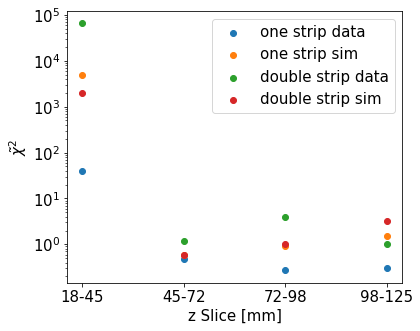

In [24]:
plt.figure(figsize = (6,5))
plt.scatter(range(4),[39.49,0.48,0.27,0.3],label='one strip data')
plt.scatter(range(4),[4904.8,0.59,0.9,1.55],label='one strip sim')
plt.scatter(range(4),[65035.02,1.18,3.86,1.04],label='double strip data')
plt.scatter(range(4),[1968.17,0.58,1.01,3.17],label='double strip sim')
plt.legend()
plt.xticks(range(4),['{:.0f}-{:.0f}'.format(z_slice[j],z_slice[j+1]) for j in range(len(skeys))])
plt.xlabel('z Slice [mm]')
plt.ylabel(r'$\tilde{\chi}^2$')
plt.yscale('log')

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


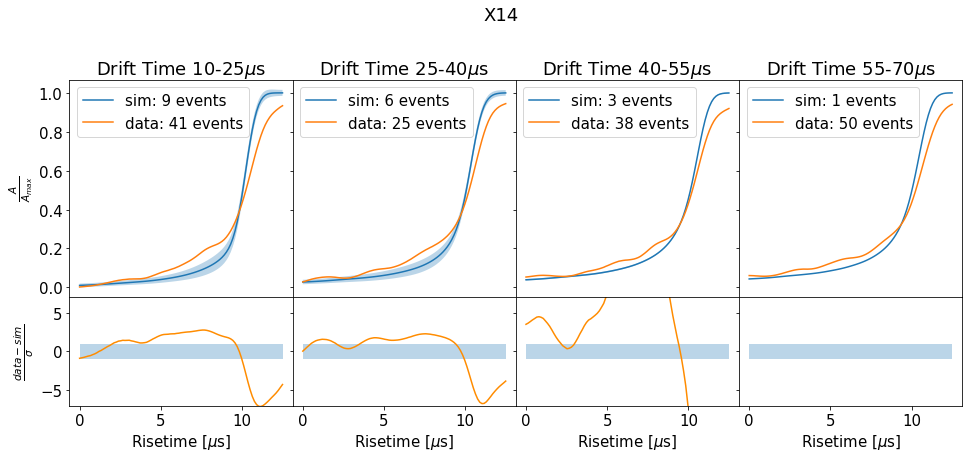

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


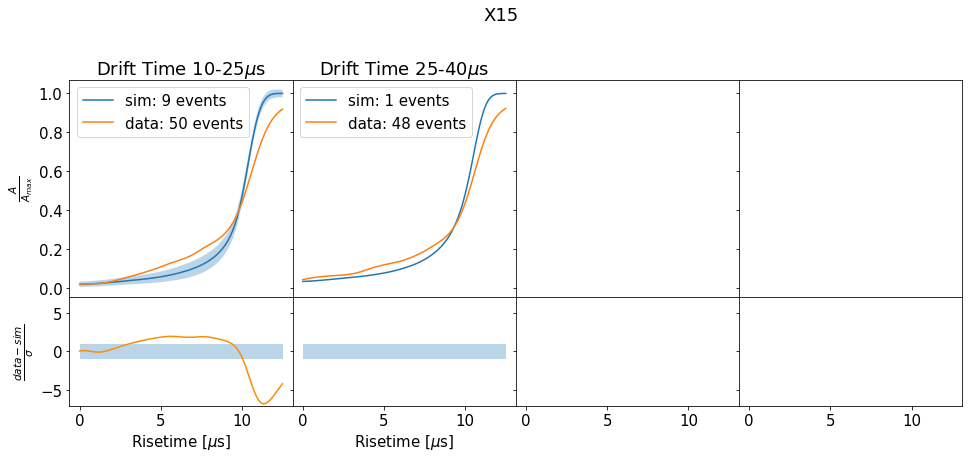

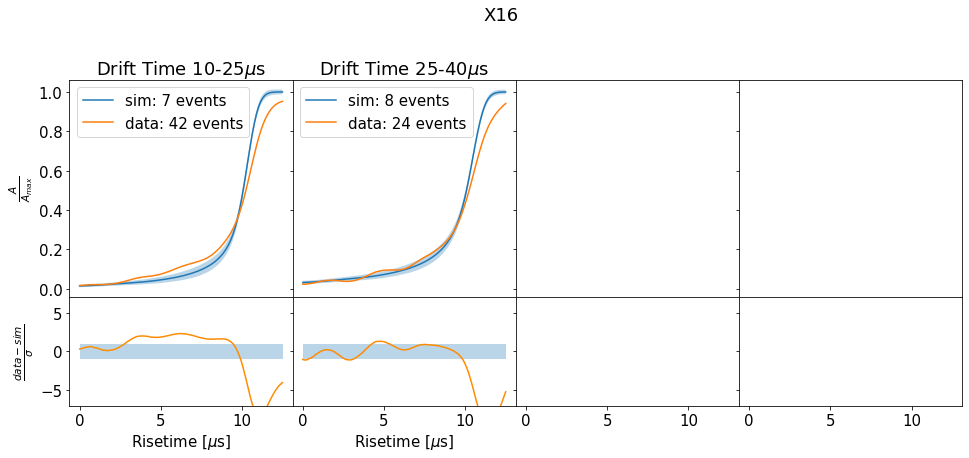

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


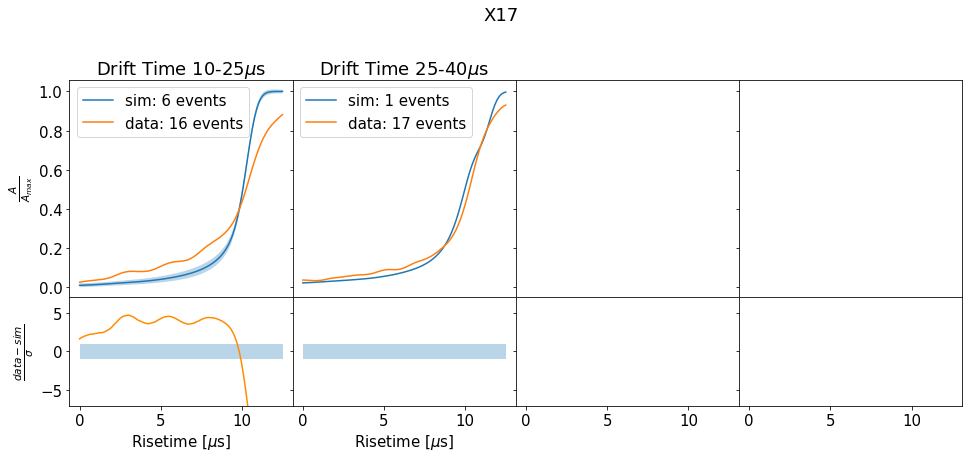

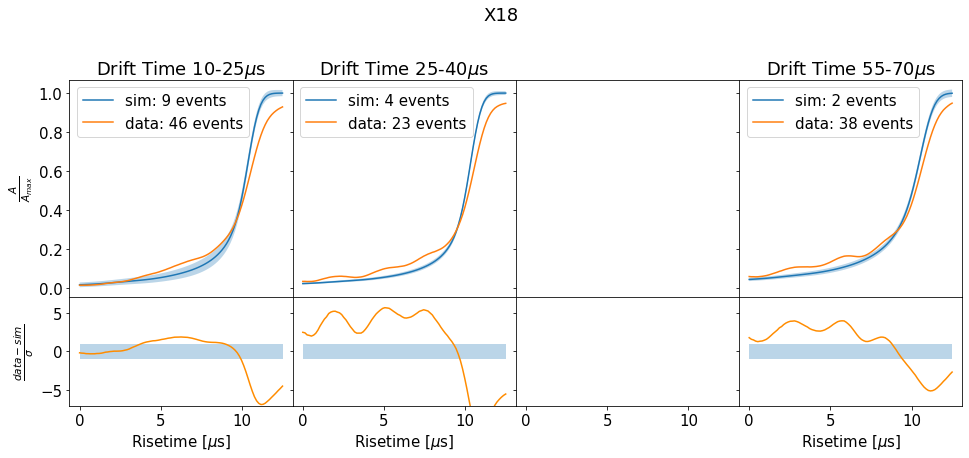

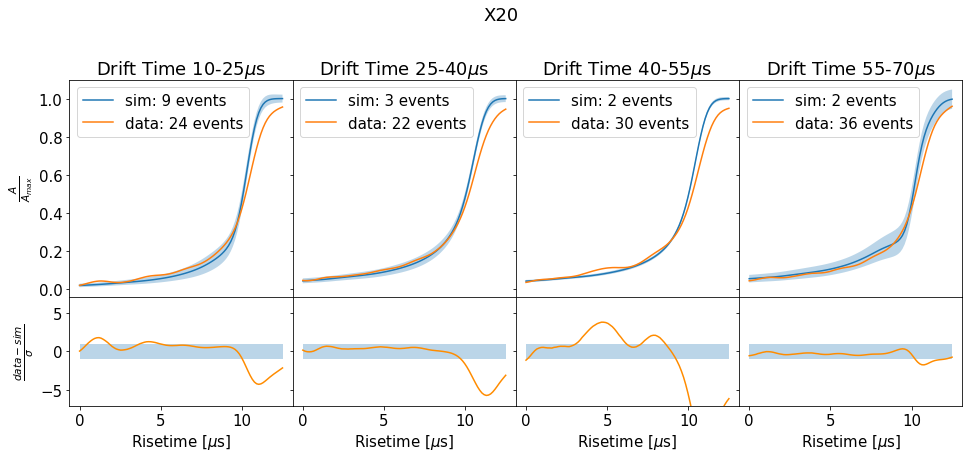

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


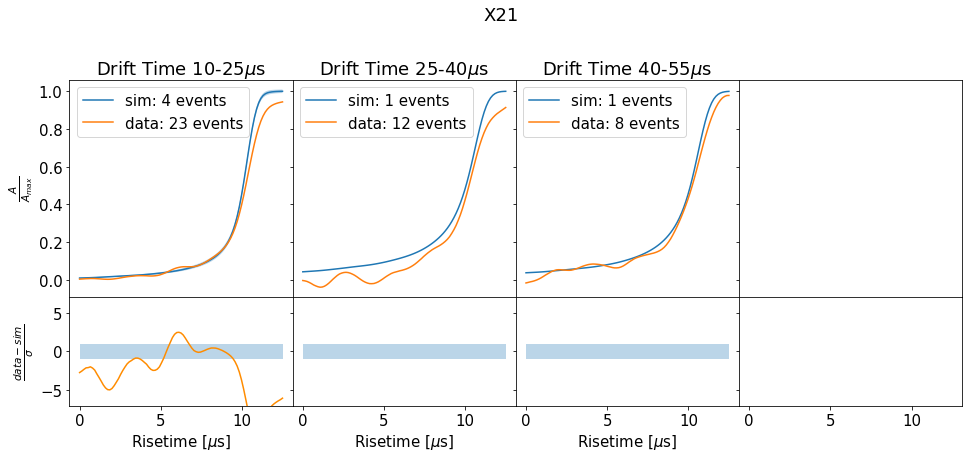

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


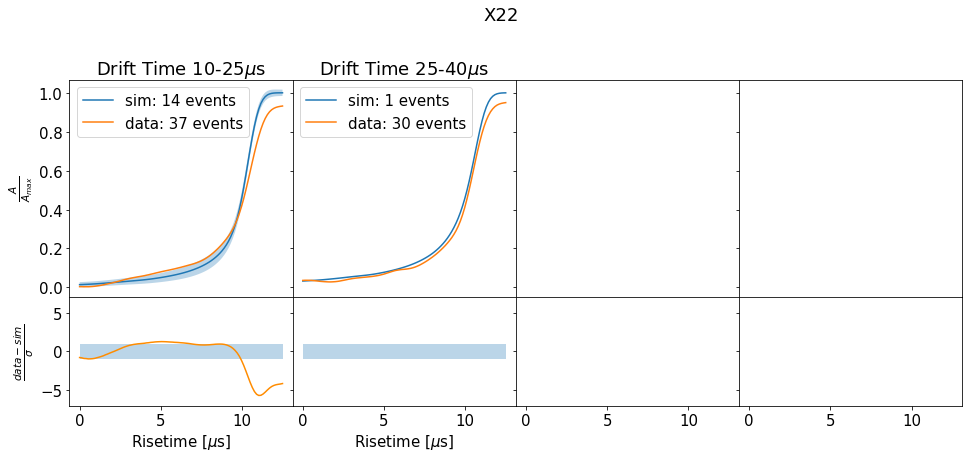

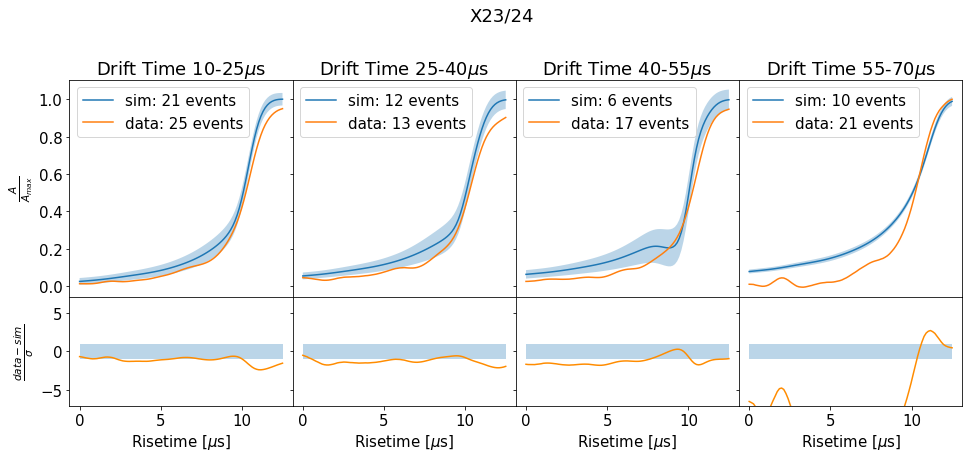

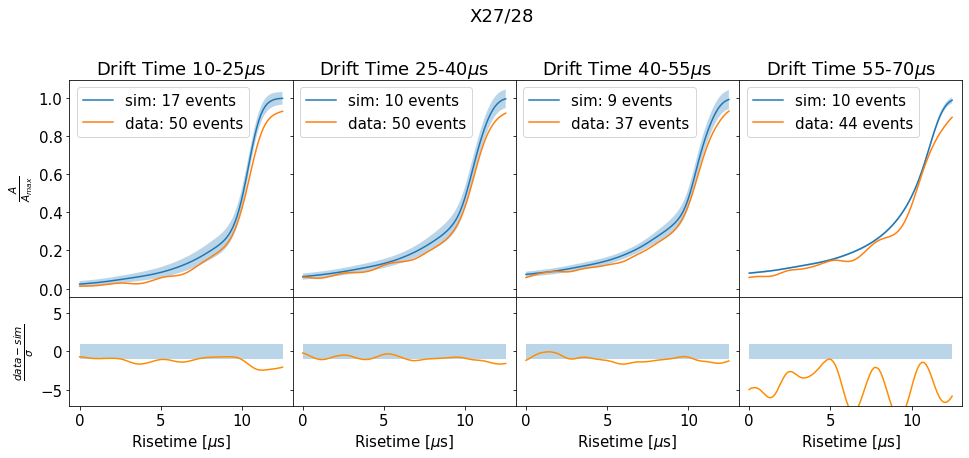

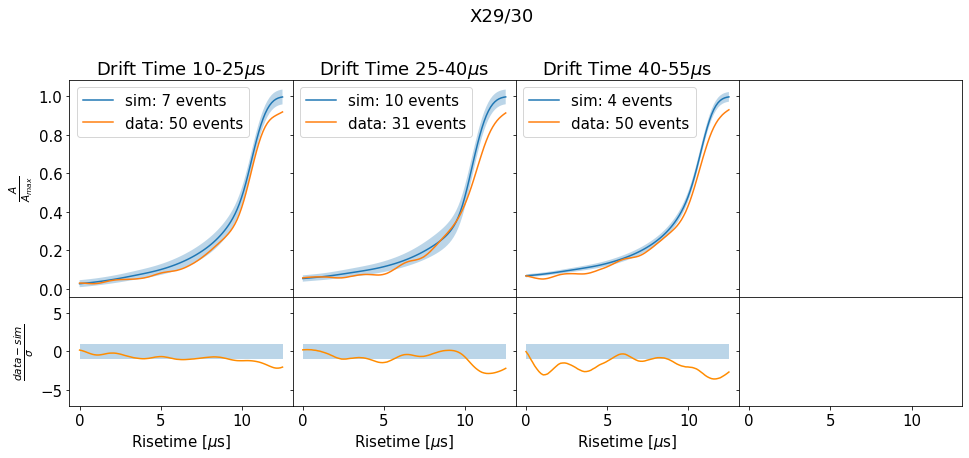

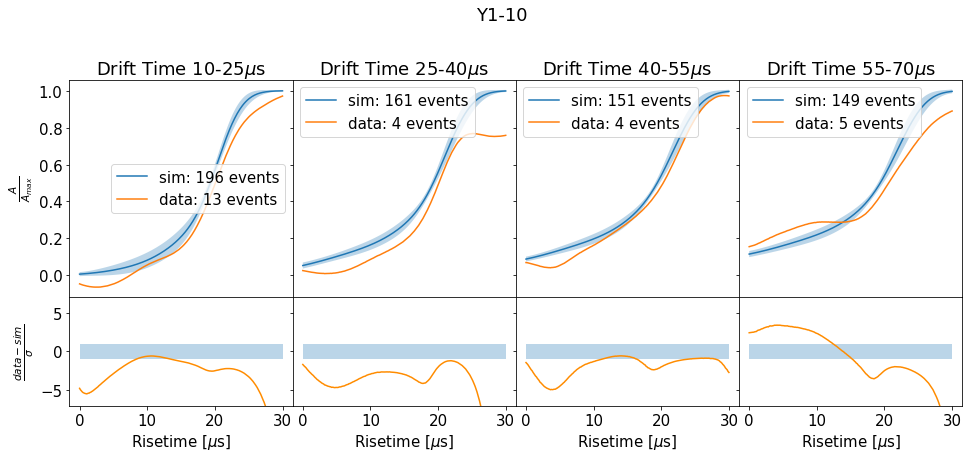

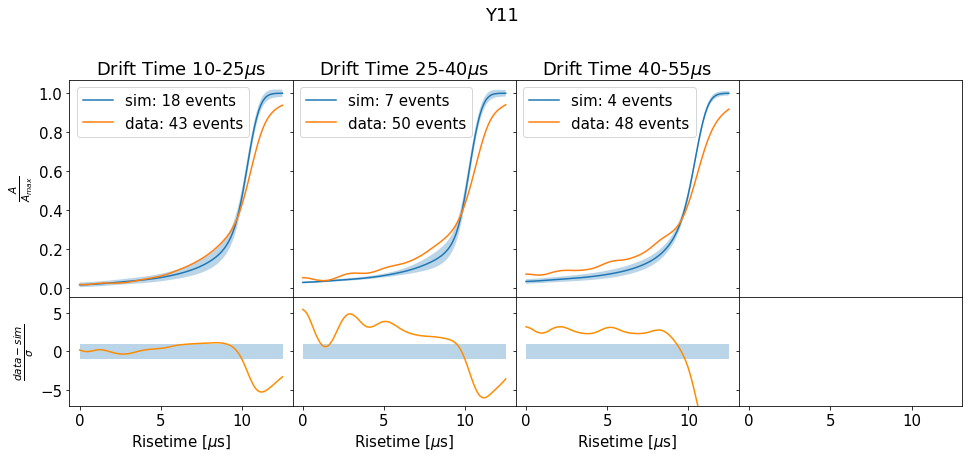

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


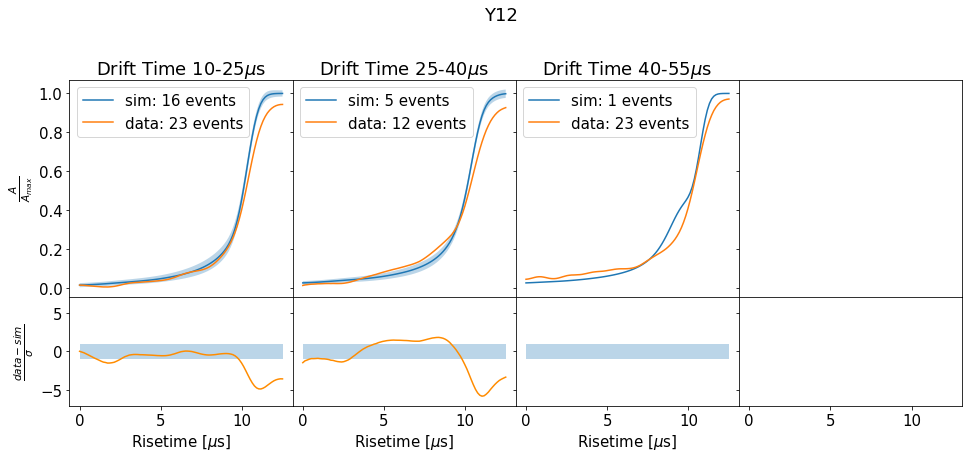

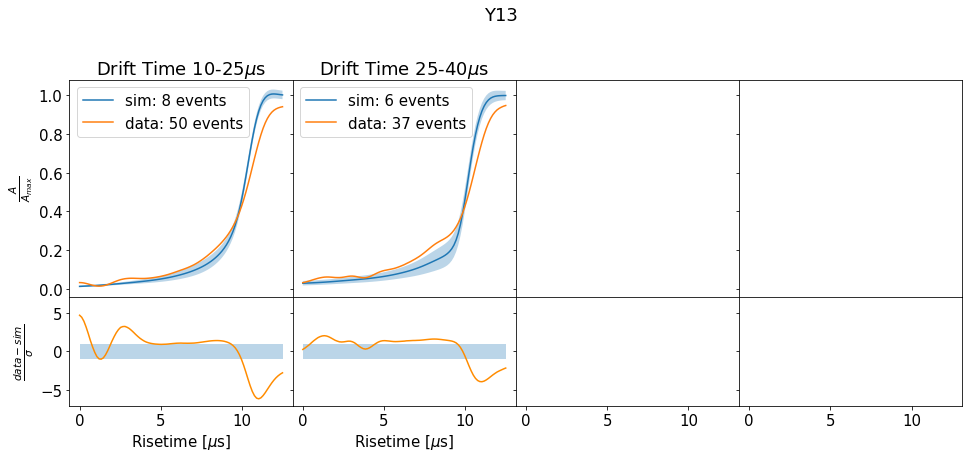

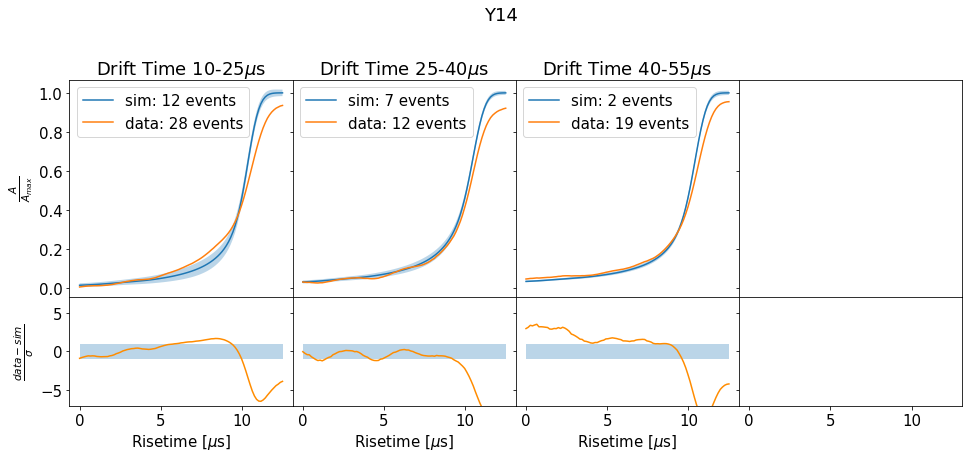

/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/g/g90/jacopod/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


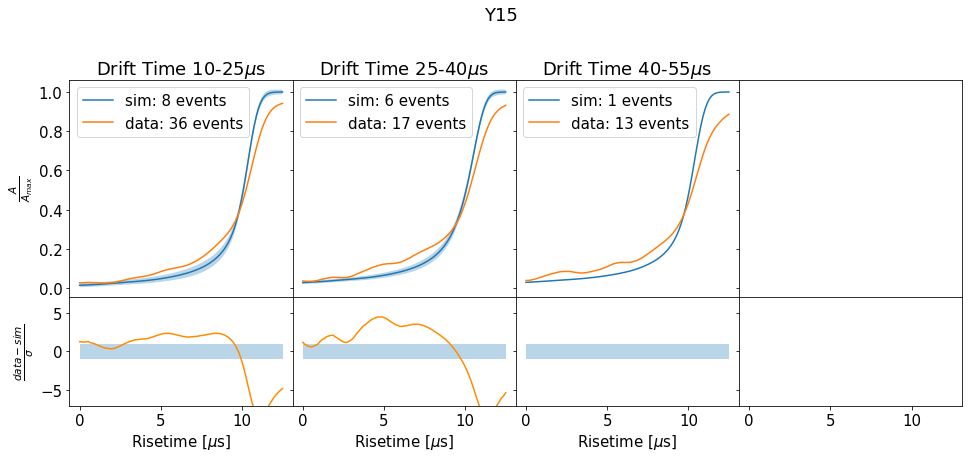

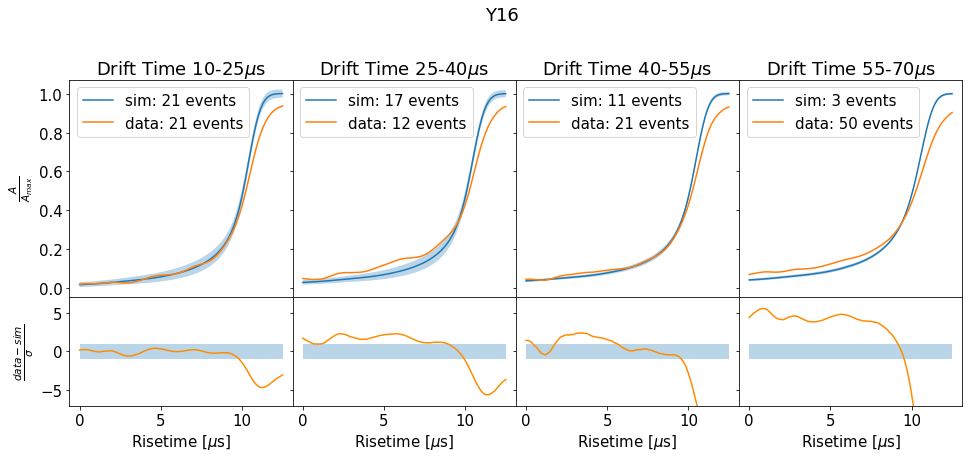

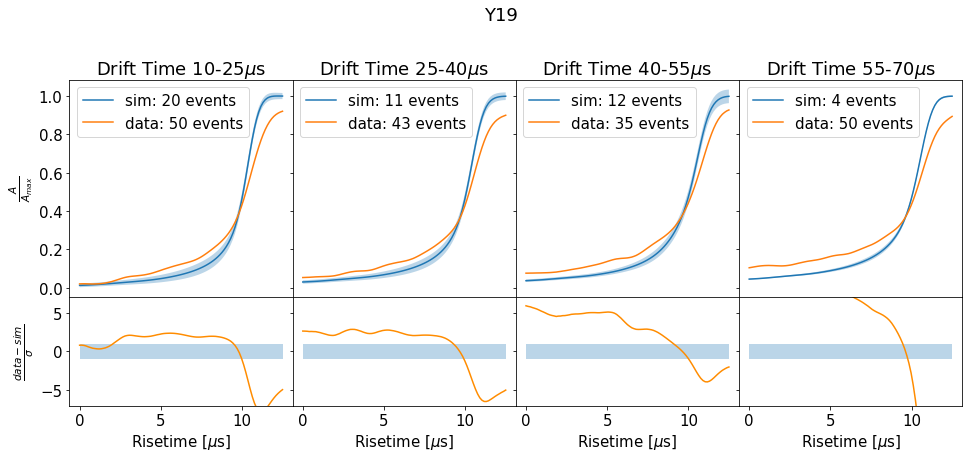

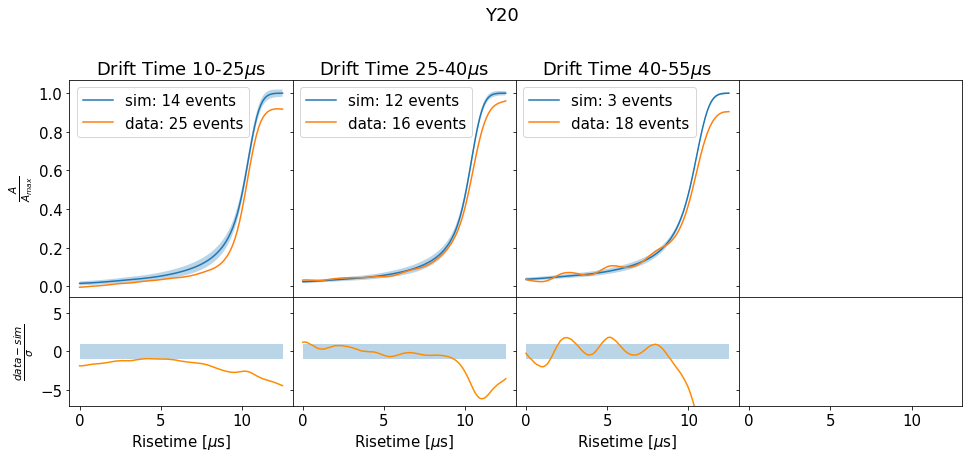

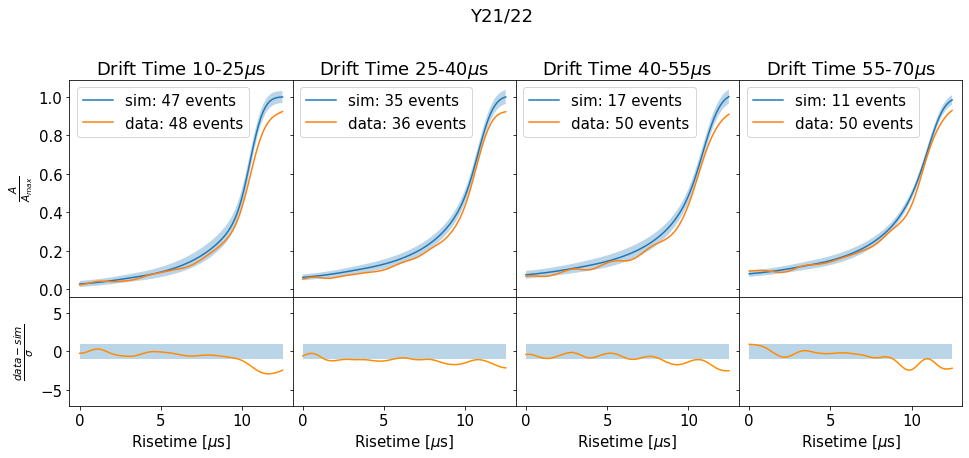

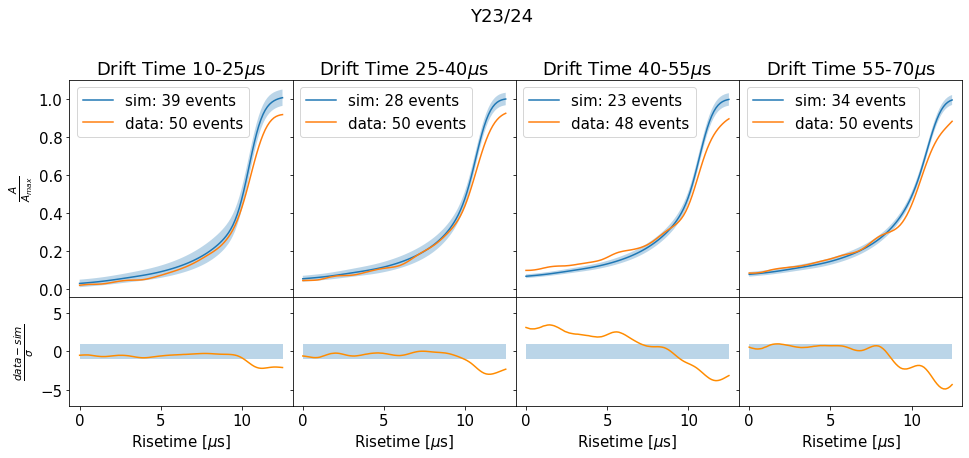

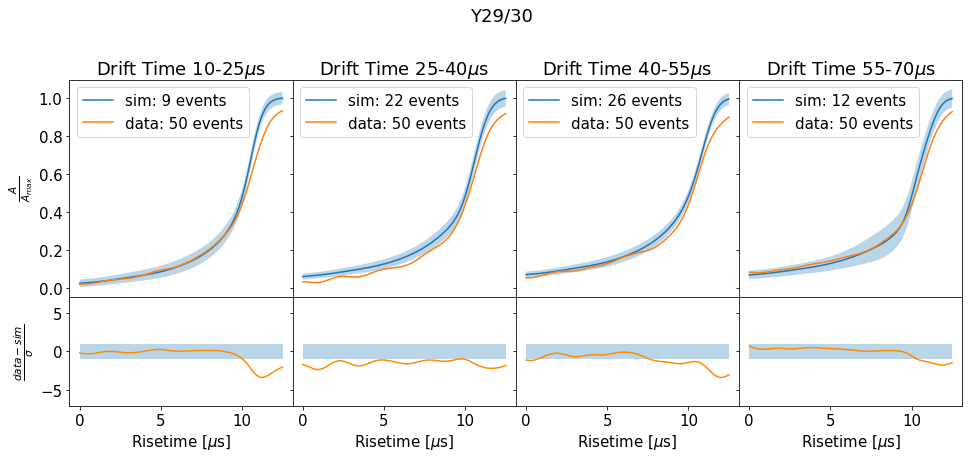

In [10]:
sim_input = pd.read_hdf('data/test_sim_t50')
data_input = pd.read_hdf('data/test_data_t50')
keys = sim_input.keys()
ks1 = []
noise = []
number_of_wfm = []
for ch in analysis_config.channel_map['ChannelName']:
    if ch =='1-3':
        continue
    if sim_input.loc[ch].isna().all():
        ks1.append(-1000)
        continue
    sim_sample = len(sim_input['10-25'][ch][1])
    data_sample = len(data_input['10-25'][ch][1])
    if ch == 'Y1-10':
        comparison_window_us = 3*10.0
    else:
        comparison_window_us = 5*2.5
    fig,ax = plt.subplots(2,len(keys),sharex=True,sharey='row',\
                          gridspec_kw={'wspace': 0,'hspace': 0,'height_ratios': [2, 1]})
    fig.set_size_inches(16,6)
    plt.suptitle(ch,y=1.05)
    ks_avg = 0
    num_wfm = 0
    num_wfm_sum = 0
    denominator = 0
    ax[0,0].set_ylabel(r'$\frac{A}{A_{max}}$')
    ax[1,0].set_ylabel(r'$\frac{data-sim}{\sigma}$')
    for i,k in enumerate(keys):
        try:
            downsampled_data = data_input[k][ch][1][::int(data_sample/sim_sample)][1:sim_sample+1]
            sim_label = 'sim: %i events'%sim_input[k][ch][0]
            data_label = 'data: %i events'%data_input[k][ch][0]
            sim_mean = sim_input[k][ch][1]
            sim_delta = gaussian_filter(sim_input[k][ch][2],10)
            ax[0,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                               alpha=0.3)
            ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label=sim_label)
            ax[0,i].plot(np.linspace(0,comparison_window_us,sim_sample),downsampled_data,label=data_label)
            ax[0,i].set_title('Drift Time %s$\mu$s'%k)
            ax[0,i].legend(prop={'size': 15})
            #ax[0,i].set_xlim(0.0,12.5)
            #ax[0,i].set_ylim(0.0,1.0)
            ax[1,i].fill_between(np.linspace(0,comparison_window_us,sim_sample),-1,1,alpha=0.3,label='1-$\sigma$ band')
            ax[1,i].plot(np.linspace(0,comparison_window_us,sim_sample),(downsampled_data-sim_mean)/sim_delta,\
                         color='darkorange')
            ax[1,i].set_ylim(-7,7)
            ax[1,i].set_xlabel('Time [$\mu$s]')
            ks_avg += fit_test_mod(downsampled_data,sim_input[k][ch][1],sim_delta)*sim_input[k][ch][0]
            denominator += sim_input[k][ch][0]
            num_wfm += data_input[k][ch][0]*data_input[k][ch][0]
            num_wfm_sum += data_input[k][ch][0]
        except TypeError:
            continue
    ks1.append(ks_avg/denominator)
    noise.append(np.mean(df['TileStrip %s Baseline RMS'%ch]))
    number_of_wfm.append(num_wfm/num_wfm_sum)
    plt.show()

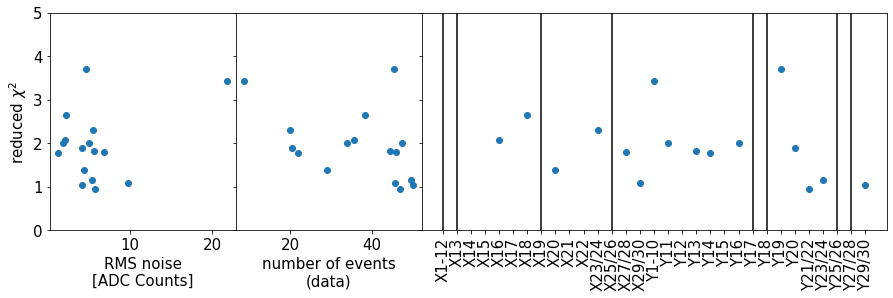

In [14]:
ch_name = data_input.index
ks = np.asarray(ks1)
fig,ax = plt.subplots(1,3,sharey=True,gridspec_kw={'wspace': 0,'width_ratios': [1, 1, 2.5]})
fig.set_size_inches(15,4)
ax[0].scatter(noise,ks[ks>-500])
ax[0].set_ylim(0,5)
ax[0].set_xlabel('RMS noise\n[ADC Counts]')
ax[0].set_ylabel('reduced $\chi^2$')
ax[1].scatter(number_of_wfm,ks[ks>-500])
ax[2].scatter(ch_name,ks)
ax[2].vlines(np.where(ks<-500),ax[2].get_ylim()[0],ax[2].get_ylim()[1])
ax[2].set_xticklabels(ch_name,rotation=90)
#ax[1].set_xlim(0,2.5)
ax[1].set_xlabel('number of events\n(data)')
plt.show()

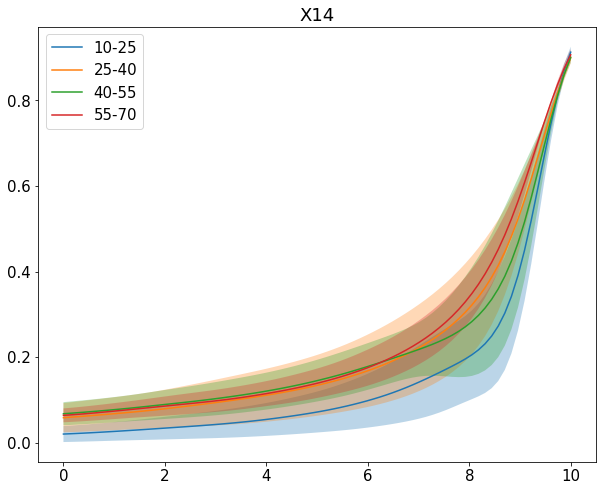

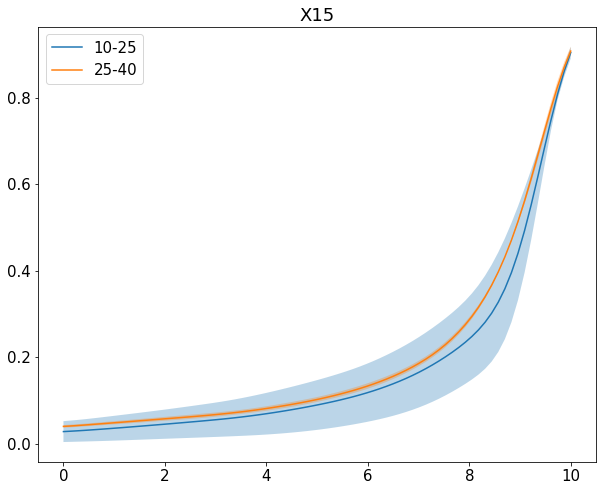

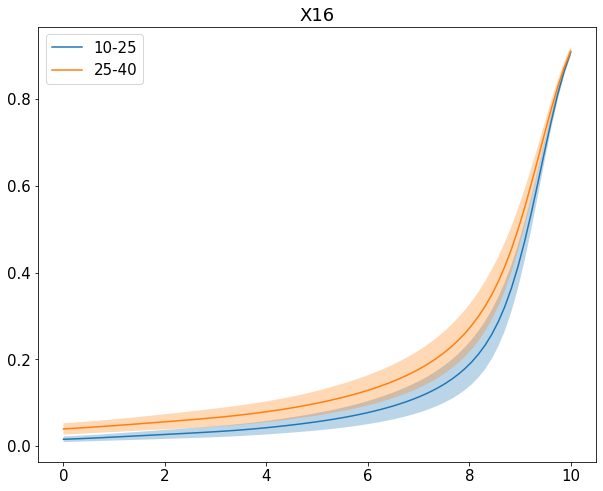

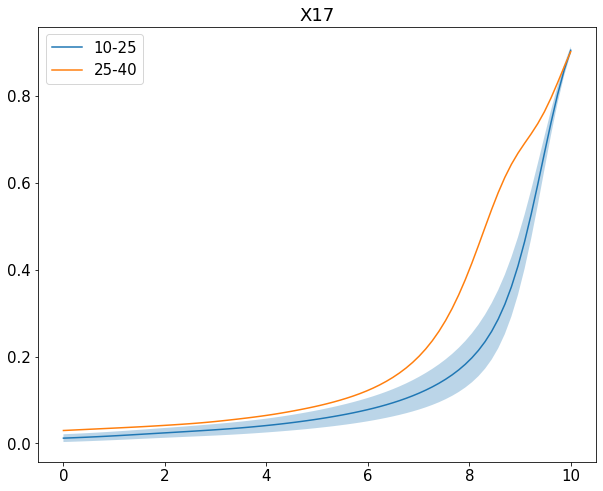

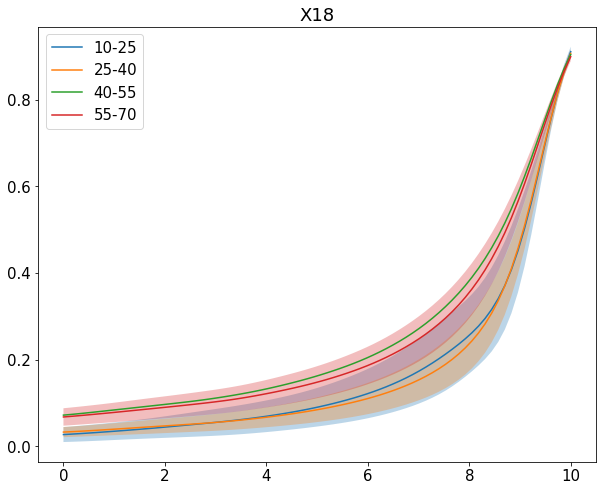

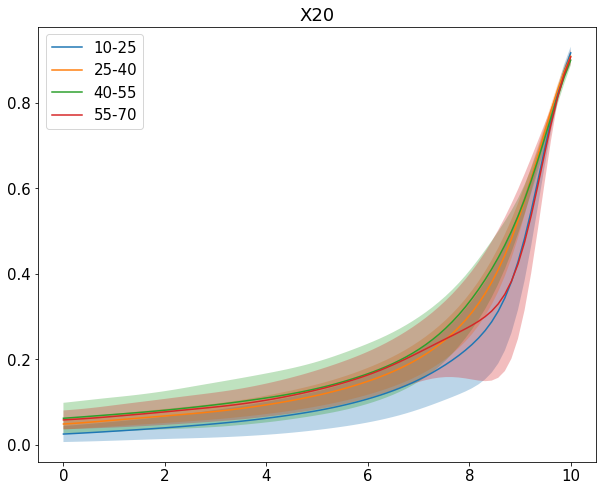

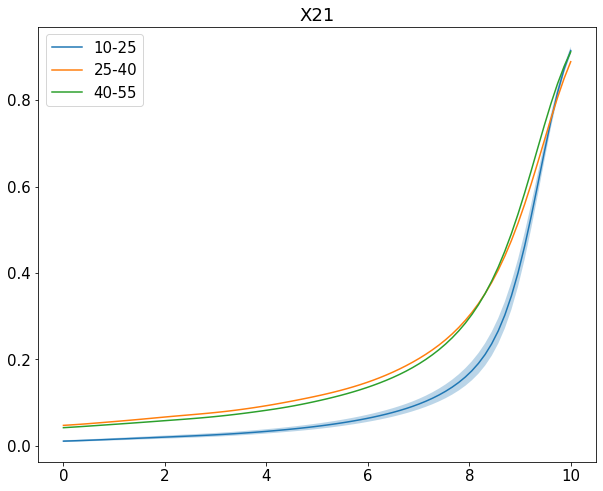

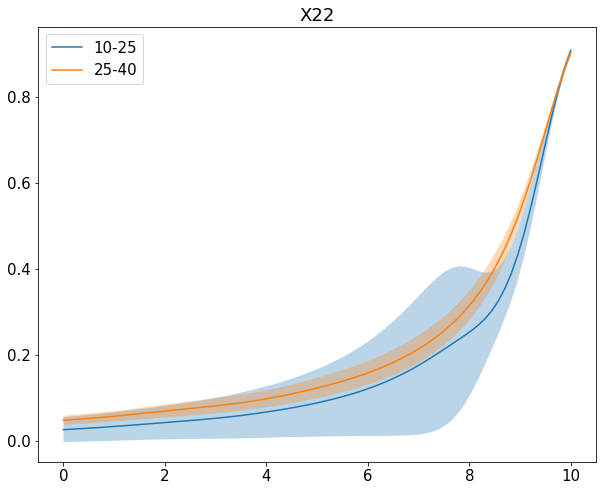

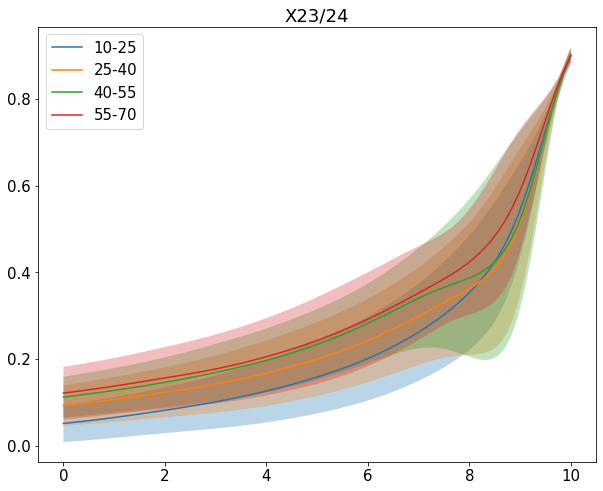

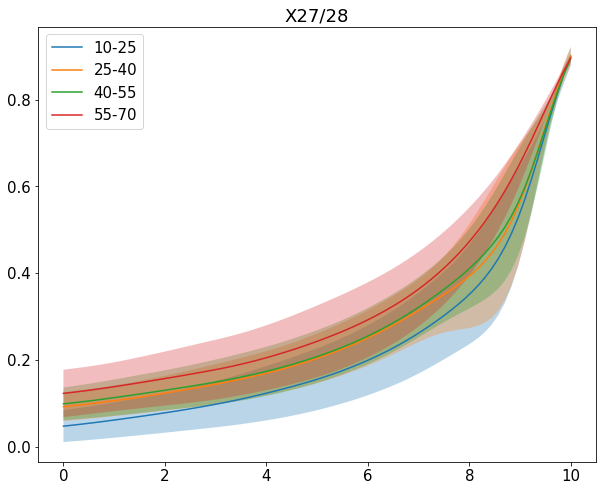

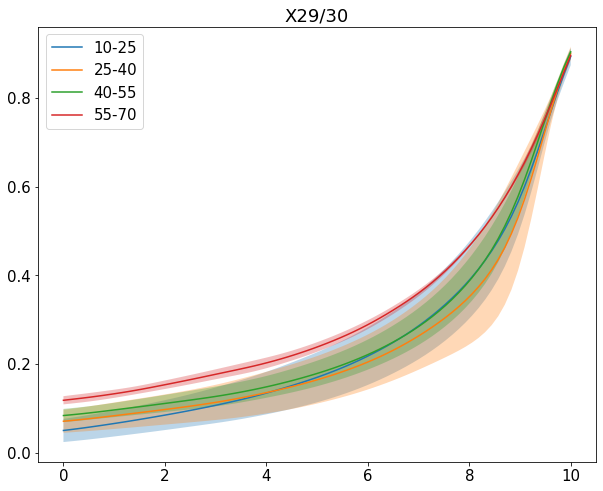

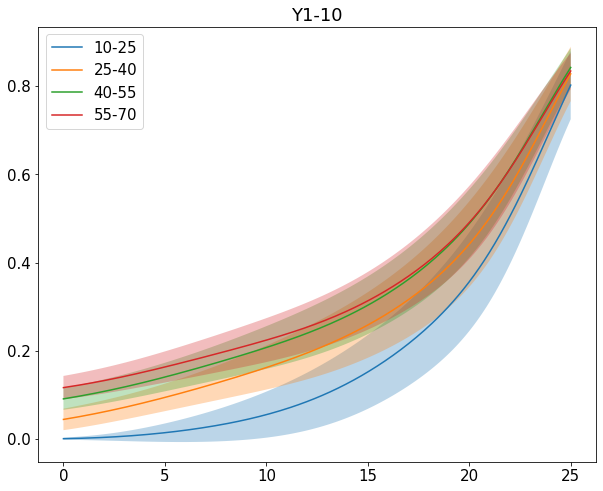

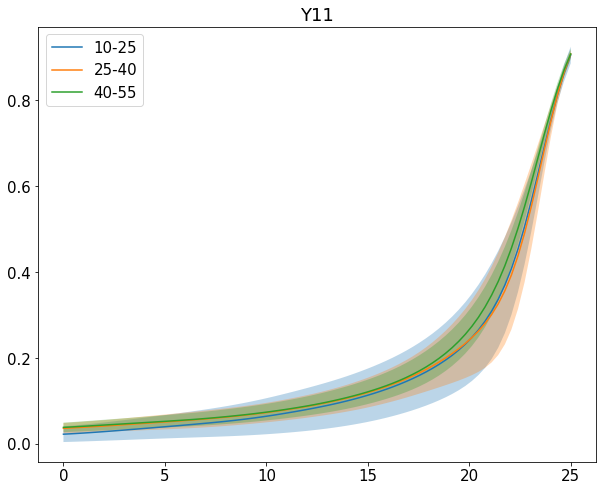

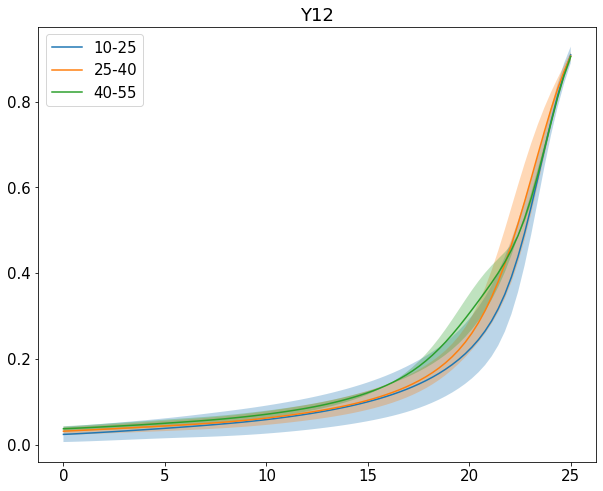

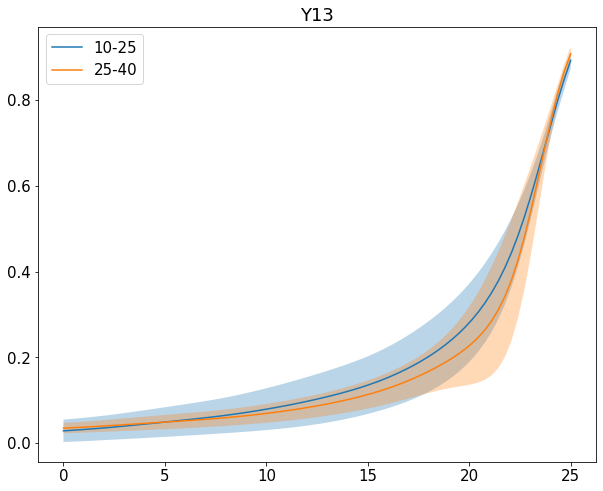

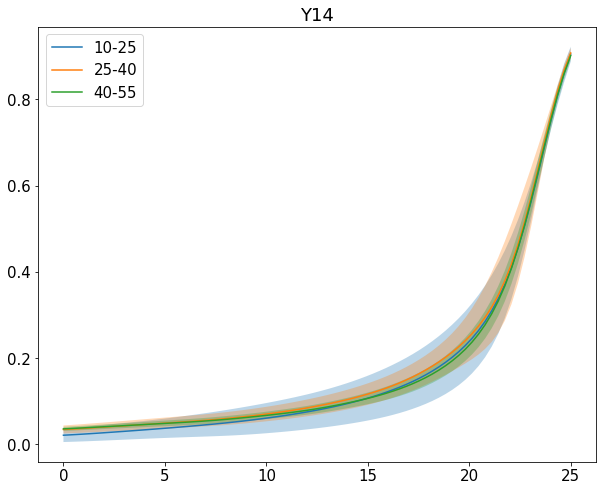

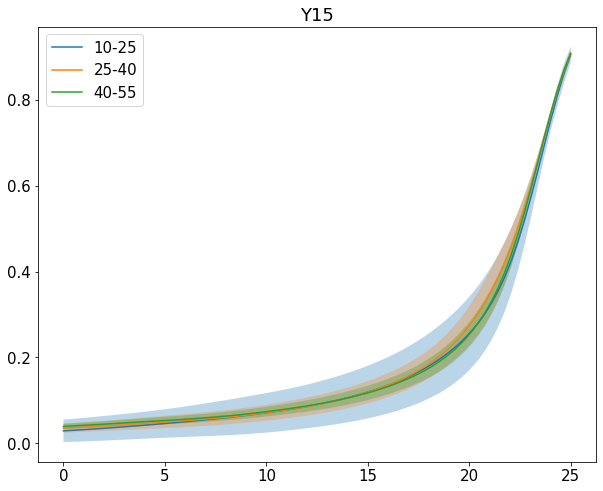

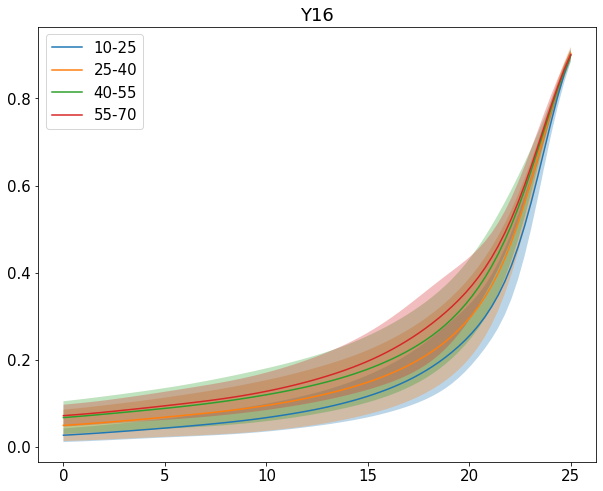

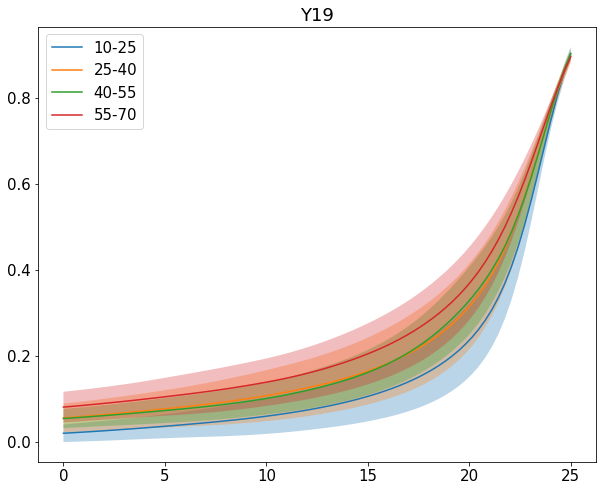

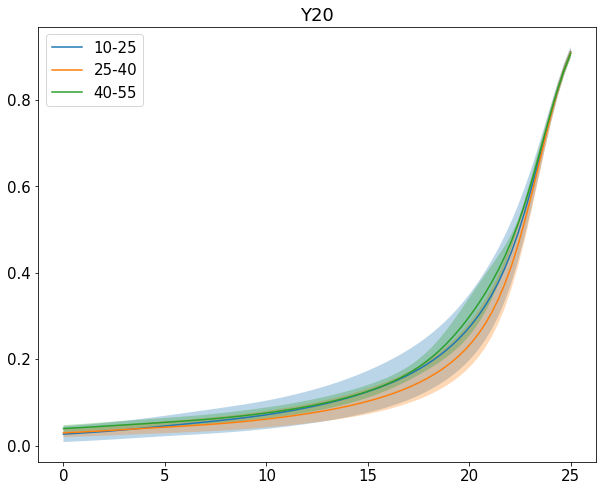

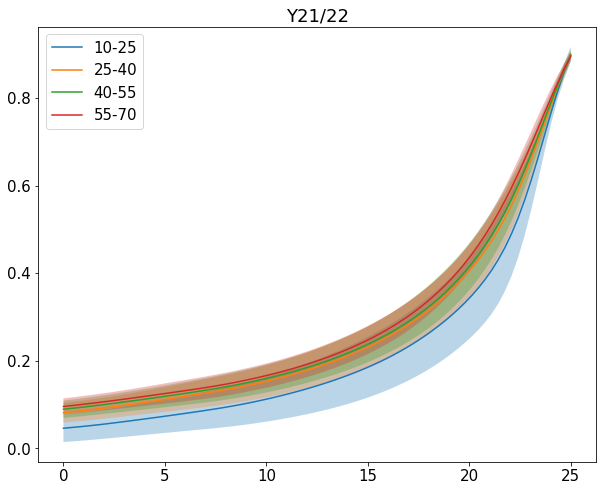

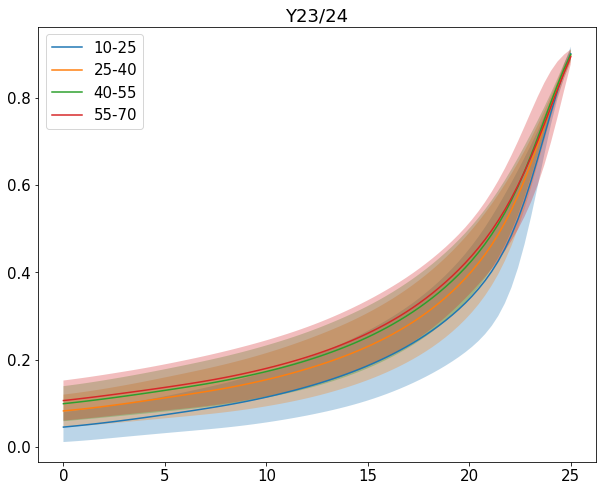

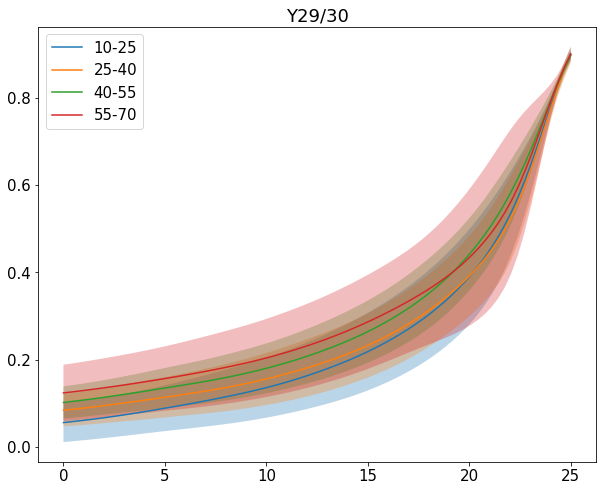

In [10]:
comparison_window_us = 10.0
ks = []
noise = []
number_of_wfm = []
for ch in analysis_config.channel_map['ChannelName']:
    if ch =='1-3':
        continue
    if sim_input.loc[ch].isna().all():
        ks.append(-1000)
        continue
    sim_sample = len(sim_input['10-25'][ch][1])
    data_sample = len(data_input['10-25'][ch][1])
    if ch == 'Y1-10':
        comparison_window_us = 25.0
    ax = plt.subplot()
    ax.set_title(ch)
    for i,k in enumerate(keys):
        try:
            sim_label = 'sim: %i events'%sim_input[k][ch][0]
            sim_mean = sim_input[k][ch][1]
            sim_delta = sim_input[k][ch][2]
            ax.fill_between(np.linspace(0,comparison_window_us,sim_sample),sim_mean-sim_delta,sim_mean+sim_delta,\
                               alpha=0.3)
            ax.plot(np.linspace(0,comparison_window_us,sim_sample),sim_mean,label=k)
            ax.legend(prop={'size': 15})
        except TypeError:
            continue
    plt.show()